In [203]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from patbert.data import utils
mimic_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\ehr_preprocess\\data\\processed\\mimic-iii-clinical-database-1.4"

## Patients

In [100]:
patients = pd.read_parquet(join(mimic_path,"patients_info.parquet"))
print(patients.GENDER.value_counts())
print(patients.DEATHDATE.notnull().sum(), 'dead patients')
cat_cols = ['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']
# for col in cat_cols:
    # patients[col] = patients[col].astype('category')

M    26121
F    20399
Name: GENDER, dtype: int64
15759 dead patients


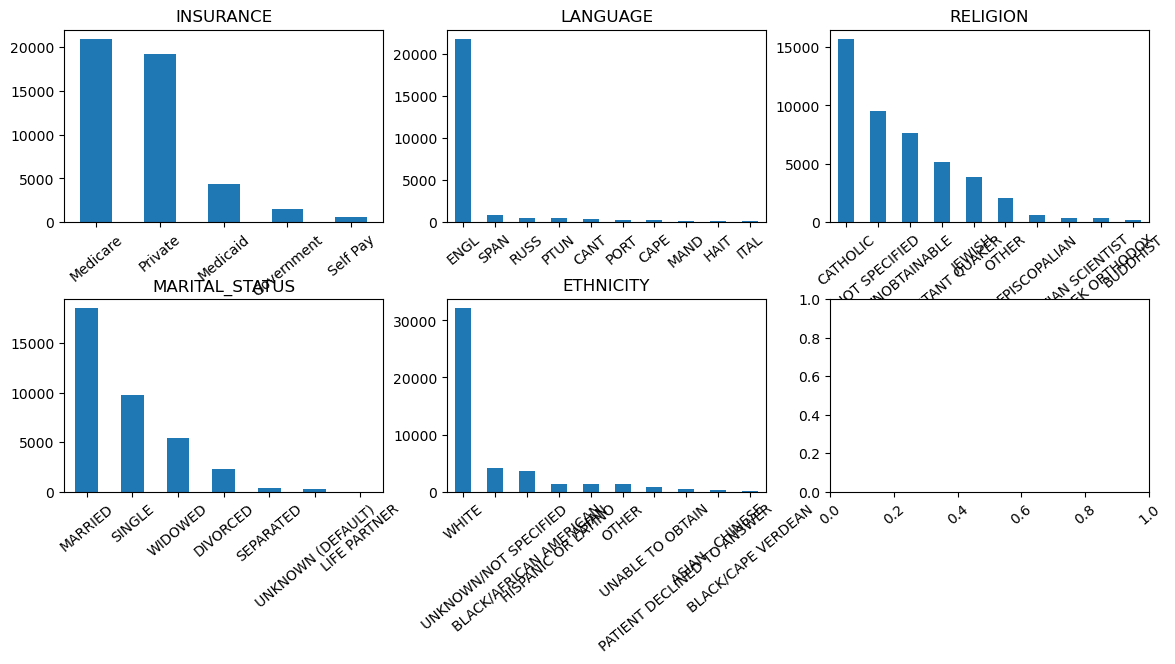

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    patients[col].value_counts()[:10].plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
# rotate xtick labels
for a in ax:
    for tick in a.get_xticklabels():
        tick.set_rotation(40)

# increase distance between subplots
fig.subplots_adjust(hspace=0.4)

<AxesSubplot: >

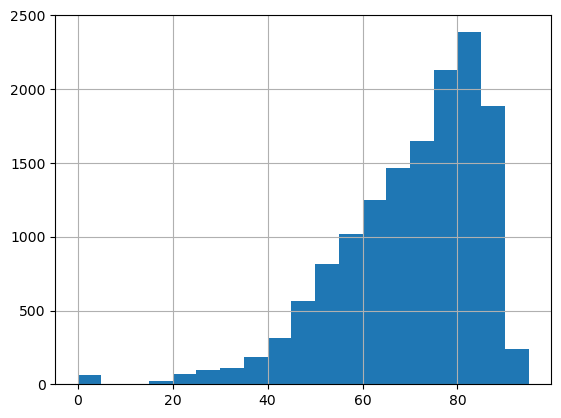

In [124]:
# compute average age of death
patients['death_age'] = patients.DEATHDATE.dt.date - patients.BIRTHDATE.dt.date
death_age = patients[patients.death_age.notnull()]['death_age'].map(lambda x: x.days / 365.25)
death_age.hist(bins=np.arange(0, 100, 5))

## Admissions

In [109]:
transfers = pd.read_parquet(join(mimic_path, "concept.transfer.parquet"))
transfers["TIMESTAMP"] = transfers["TIMESTAMP"].dt.date
transfers["TIMESTAMP_END"] = transfers["TIMESTAMP_END"].dt.date

In [118]:
transfers.CONCEPT.value_counts()

TICU          61532
THOSPITAL     58976
TEMERGENCY    30877
Name: CONCEPT, dtype: int64

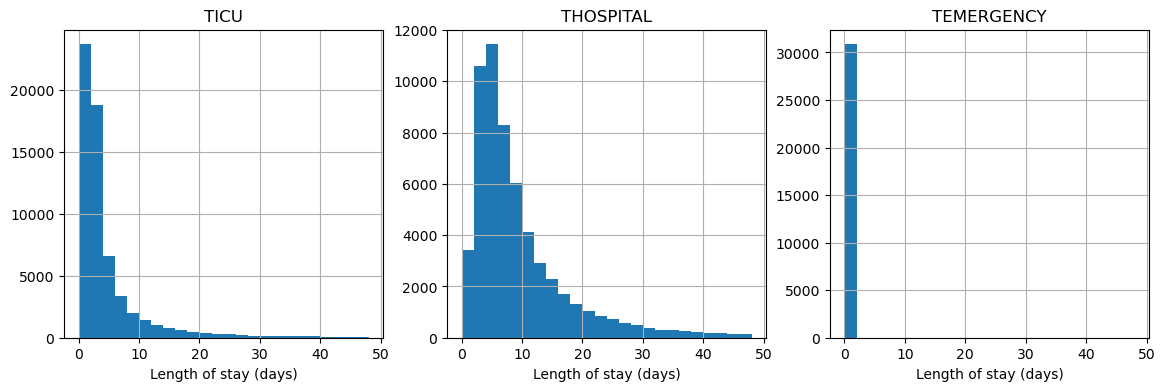

In [125]:
transfers['LOS'] = (transfers.TIMESTAMP_END - transfers.TIMESTAMP).map(lambda x: x.days)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(['TICU', 'THOSPITAL','TEMERGENCY']):
    transfers[transfers.CONCEPT==col]['LOS'].hist(ax=ax[i], bins=np.arange(0,50,2))
    ax[i].set_title(col)
    ax[i].set_xlabel('Length of stay (days)')

## Diagnoses

In [164]:
diag = pd.read_parquet(join(mimic_path, "concept.diag.parquet"))
print(len(diag), diag.CONCEPT.nunique())

651047 6985


Text(0.5, 0, 'Number of diagnoses')

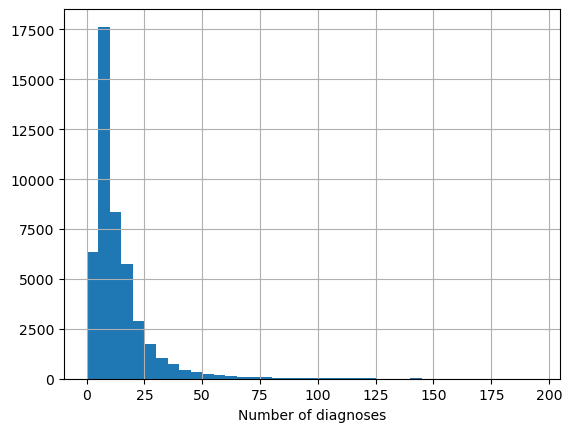

In [142]:
diag.groupby('PID').CONCEPT.count().sort_values( ascending=False).hist(bins=np.arange(0, 200, 5))
plt.xlabel('Number of diagnoses')

Text(0.5, 0, 'Frequency of diagnosis')

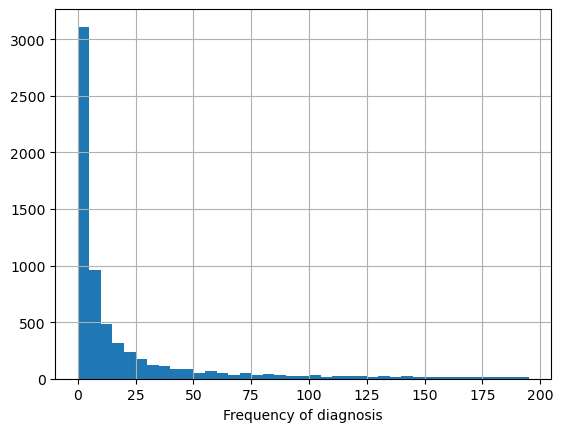

In [145]:
diag.CONCEPT.value_counts().hist(bins=np.arange(0, 200, 5))
plt.xlabel('Frequency of diagnosis')

Text(0.5, 0, 'Frequency of diagnosis')

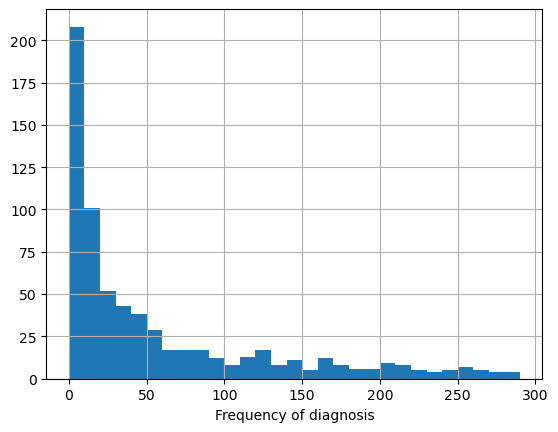

In [152]:
# group diagnosis 
diag['CONCEPT_GROUP'] = diag.CONCEPT.map(lambda x: x[:4])
diag.CONCEPT_GROUP.value_counts().hist(bins=np.arange(0, 300, 10))
plt.xlabel('Frequency of diagnosis')

## Procedures

In [163]:
pro = pd.read_parquet(join(mimic_path, "concept.pro.parquet"))
print(len(pro), pro.CONCEPT.nunique())
pro.head()

240095 2009


,PID,ADMISSION_ID,VALUE,CONCEPT,TIMESTAMP,VALUE_UNIT
95085,2,163353,1,P9955,2138-07-21 15:48:00,SEQ_NUM
45149,3,145834,1,P9604,2101-10-31 13:58:00,SEQ_NUM
45150,3,145834,2,P9962,2101-10-31 13:58:00,SEQ_NUM
45151,3,145834,3,P8964,2101-10-31 13:58:00,SEQ_NUM
45152,3,145834,4,P9672,2101-10-31 13:58:00,SEQ_NUM


Text(0.5, 0, 'Number of procedures')

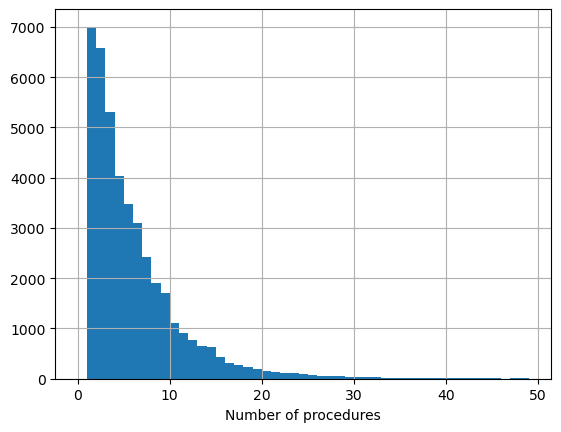

In [162]:
pro.groupby('PID').CONCEPT.count().sort_values( ascending=False).hist(bins=np.arange(0, 50, 1))
plt.xlabel('Number of procedures')

## Medication

In [166]:
med = pd.read_parquet(join(mimic_path, "concept.med.parquet"))
print(len(med), med.CONCEPT.nunique())
med.head()

4156450 4525


,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,CONCEPT,VALUE,VALUE_UNIT
109,2,163353,243653,2138-07-18,MAmpicillin Sodium,500,mg
107,2,163353,243653,2138-07-18,MNEO*IV*Gentamicin,15.5,mg
110,2,163353,243653,2138-07-18,MSend 500mg Vial,1,VIAL
108,2,163353,243653,2138-07-18,MSyringe (Neonatal) *D5W*,2.4,ml
130,4,185777,294638,2191-03-16,MAcetaminophen,325-650,mg


In [229]:
utils.visualize_encoded(med.sample(4000), 'CONCEPT', n_points=4, n_neighbors=4)

c:\users\fjn197\phd\projects\phair\pipelines\patbert\patbert\data\utils.py:10: UserWarning: The "similarity" argument is deprecated since dirty_cat 0.3, and will be removed in 0.5.The n-gram similarity is the only one currently supported. 
  enc = SimilarityEncoder()
c:\Users\fjn197\Miniconda3\envs\patbert\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## Labevents

In [165]:
lab = pd.read_parquet(join(mimic_path, "concept.lab.parquet"))
print(len(lab), lab.CONCEPT.nunique())
lab.head()

27854055 691


,PID,ADMISSION_ID,TIMESTAMP,VALUE,VALUE_UNIT,CONCEPT
607,2,163353,2138-07-17 20:48:00,0,%,L26498-6
605,2,163353,2138-07-17 20:48:00,0,%,L28541-1
599,2,163353,2138-07-17 20:48:00,0,%,L4544-3
597,2,163353,2138-07-17 20:48:00,0,%,L704-7
598,2,163353,2138-07-17 20:48:00,0,%,L711-2
